# Repairing geographic locations, place names, and extracted data for the NWT Climate Explorer.

## Issue
The location of Inuvik, NWT was found to be incorrect by about ten degrees of longitude. A closer examination of all point locations used by the web tool found that many of the geographic coordinates were in need of refinement and that some place names needed to be updated.

## Fix
A revised spreadsheet of NWT geographic locations was produced (see https://github.com/ua-snap/geospatial-vector-veracity/blob/main/vector_data/point/nwt_point_locations.csv) and used to re-extract downscaled data for each location.

## Validation
This notebook will compare the existing data to the newly extracted data and check for data model integrity and for qualitative similarity. 

In [1]:
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from glob import glob

The previously extracted CSV files (incorrect for Inuvik) are still on branch `master` while the freshly extracted data is on branch `inuvik-rextraction` (forgive the missing 'e'). I want to pull both sets of CSV files and compare them. I'll use the `subprocess` module to checkout the different git branches. This is probably not advisable and should only be used if both branches are up to date (no changes, nothing staged, etc.) but it is fun to contain this type of thing in a notebook. Using git in the notebook is confusing (but fun!) because it is sensitive to the state of the git repository as it was left in the terminal. Only two branches are relevant here so I can be agnostic regarding which branch this "starts" on.

In [1]:
di_branches = defaultdict()
di_branches['master'] = 'inuvik-rextraction'
di_branches['inuvik-rextraction'] = 'master'

def which_branch():
    proc_branch = subprocess.Popen(["git", "branch"], stdout=subprocess.PIPE, universal_newlines=True)
    out_branch = proc_branch.communicate()[0].splitlines()
    current_branch = [x for x in out_branch if x[0] == '*'][0].split(' ')[-1]
    return current_branch

def switch_branch(di_branches):
    checkout = subprocess.Popen(["git", "checkout", di_branches[which_branch()]],
                                stdout=subprocess.PIPE,
                                universal_newlines=True)

NameError: name 'defaultdict' is not defined

In [3]:
scenarios = ['historical', 'rcp45', 'rcp60', 'rcp85']

di_csv = defaultdict()

def qa_prep():
    di_csv[which_branch()] = {}
    for sc in scenarios:
        di_csv[which_branch()][sc] = {}
        df = pd.read_csv(glob('../data/*' + sc + '*.csv')[0])
        di_csv[which_branch()][sc]['csv'] = df
        di_csv[which_branch()][sc]['shape'] = df.shape
        di_csv[which_branch()][sc]['models'] = sorted(list(df.model.unique()))
        di_csv[which_branch()][sc]['years'] = sorted(list(df.model.unique()))
        try:
            di_csv[which_branch()][sc]['place_names'] = sorted(list(df.community.unique()))
        except:
            di_csv[which_branch()][sc]['place_names'] = sorted(list(df.name.unique()))
qa_prep()    
di_csv

defaultdict(None,
            {'master': {'historical': {'csv':        Unnamed: 0  year  month   tas    pr    scenario      model    community
               0               0  1850      1 -31.2  13.0  historical  GISS-E2-R      Aklavik
               1               1  1850      2 -29.4  12.0  historical  GISS-E2-R      Aklavik
               2               2  1850      3 -23.1  10.0  historical  GISS-E2-R      Aklavik
               3               3  1850      4 -15.0  10.0  historical  GISS-E2-R      Aklavik
               4               4  1850      5  -3.6  15.0  historical  GISS-E2-R      Aklavik
               ...           ...   ...    ...   ...   ...         ...        ...          ...
               49627        7891  1990      8  13.6  44.0  historical  5ModelAvg  Yellowknife
               49628        7892  1990      9   6.5  30.0  historical  5ModelAvg  Yellowknife
               49629        7893  1990     10  -1.5  36.0  historical  5ModelAvg  Yellowknife
           

In [4]:
switch_branch(di_branches)

In [5]:
qa_prep()

In [6]:
# Expectation: models and time spans (years) did not change across extractions
for sc in scenarios:
    model_check = di_csv['master'][sc]['models'] == di_csv['fix-point-locations-and-names'][sc]['models']  
    yr_check = di_csv['master'][sc]['years'] == di_csv['fix-point-locations-and-names'][sc]['years']
    print(sc, model_check, yr_check)    

historical True True
rcp45 True True
rcp60 True True
rcp85 True True


However, changes to the place names were made, and the number of communities was reduced by one in freshly extracted data. Bechoko was formerly represented by separate extractions for Rae and Edzo, two former communities that are are only a few miles apart. They are now together...see encyclopedia article.

In [7]:

for sc in scenarios:
    print(sc)
    old_places = di_csv['master'][sc]['place_names']
    new_places = di_csv['fix-point-locations-and-names'][sc]['place_names']
    old_locs_not_in_new = list(set(old_places) - set(new_places))
    new_locs_not_in_old = list(set(new_places) - set(old_places))
    print(sorted(old_locs_not_in_new))
    print(sorted(new_locs_not_in_old))
    print("Old places: %d" % len(old_places))
    print("New places: %d" % len(new_places))



historical
['Behchoko (Edzo)', 'Behchoko (Rae)', 'Daring Lake Research Stn', 'Detah', 'Gameti', "Lutselk'e", "N'Dilo", 'Nechalacho', 'Pine Point Mine (Tamerlane)', 'Trout Lake', 'Wekweeti', 'Whati']
['Behchokǫ̀', 'Daring Lake Research Station', 'Dettah', 'Gamètì', 'Ndilǫ', 'Nechalacho/Thor Lake', 'Pine Point Mine', 'Sambaa K’e', 'Wekweètì', 'Whatì', 'Łutselkʼe']
Old places: 47
New places: 46
rcp45
['Behchoko (Edzo)', 'Behchoko (Rae)', 'Daring Lake Research Stn', 'Detah', 'Gameti', "Lutselk'e", "N'Dilo", 'Nechalacho', 'Pine Point Mine (Tamerlane)', 'Trout Lake', 'Wekweeti', 'Whati']
['Behchokǫ̀', 'Daring Lake Research Station', 'Dettah', 'Gamètì', 'Ndilǫ', 'Nechalacho/Thor Lake', 'Pine Point Mine', 'Sambaa K’e', 'Wekweètì', 'Whatì', 'Łutselkʼe']
Old places: 47
New places: 46
rcp60
['Behchoko (Edzo)', 'Behchoko (Rae)', 'Daring Lake Research Stn', 'Detah', 'Gameti', "Lutselk'e", "N'Dilo", 'Nechalacho', 'Pine Point Mine (Tamerlane)', 'Trout Lake', 'Wekweeti', 'Whati']
['Behchokǫ̀', 'Daring

In [8]:
# OK so we reduced the number of communities by one
# so the shape of the newly extracted dataframes has changed
# how many rows per community for each scenario?
# That should be the difference in dataframe shapes
for sc in scenarios:
    print(sc)
    old_shape = di_csv['master'][sc]['shape']
    new_shape = di_csv['fix-point-locations-and-names'][sc]['shape']
    row_delta = old_shape[0] - new_shape[0]
    print("Old CSV Shape:", old_shape)
    print("New CSV Shape:", new_shape)
    print("Old - New Shape Difference (Number Rows):", row_delta)
    rows_per_location = di_csv['master'][sc]['csv'].query("community == 'Inuvik'").shape[0]
    print("Shape Difference Accounted for by reduction of point locations by one:", row_delta == rows_per_location)


historical
Old CSV Shape: (49632, 8)
New CSV Shape: (48576, 8)
Old - New Shape Difference (Number Rows): 1056
Shape Difference Accounted for by reduction of point locations by one: True
rcp45
Old CSV Shape: (75576, 8)
New CSV Shape: (73968, 8)
Old - New Shape Difference (Number Rows): 1608
Shape Difference Accounted for by reduction of point locations by one: True
rcp60
Old CSV Shape: (41736, 8)
New CSV Shape: (40848, 8)
Old - New Shape Difference (Number Rows): 888
Shape Difference Accounted for by reduction of point locations by one: True
rcp85
Old CSV Shape: (64296, 8)
New CSV Shape: (62928, 8)
Old - New Shape Difference (Number Rows): 1368
Shape Difference Accounted for by reduction of point locations by one: True


I am satisfied that the data is essentially intact between the two extractions. The same time ranges, models, and scenarios are all accounted for. Now I'll do a brief qualitative examination to look at a few changes in the actual data itself - and I will certainly look at Inuvik because it was known to be incorrect.

Text(0, 0.5, 'temp (RCP 8.5)')

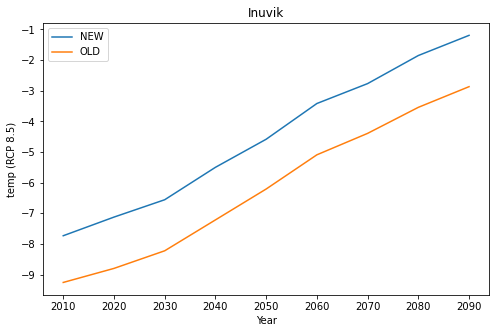

In [19]:
plt.figure(figsize=(8, 5))
old_inuvik = di_csv['master']['rcp85']['csv'].query("model == '5ModelAvg' and community == 'Inuvik'")
new_inuvik = di_csv['fix-point-locations-and-names']['rcp85']['csv'].query("model == '5ModelAvg' and name == 'Inuvik'")

plt.plot(new_inuvik[['year', 'tas']].groupby('year').mean(), label='NEW')
plt.plot(old_inuvik[['year', 'tas']].groupby('year').mean(), label='OLD')    
plt.legend()
plt.title('Inuvik')
plt.xlabel('Year')
plt.ylabel('temp (RCP 8.5)')

Text(0, 0.5, 'Precip')

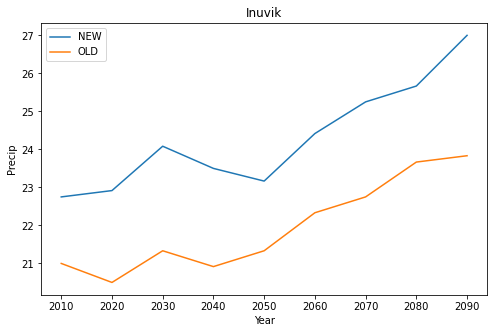

In [13]:
plt.figure(figsize=(8, 5))
old_inuvik = di_csv['master']['rcp60']['csv'].query("model == '5ModelAvg' and community == 'Inuvik'")
new_inuvik = di_csv['fix-point-locations-and-names']['rcp60']['csv'].query("model == '5ModelAvg' and name == 'Inuvik'")

plt.plot(new_inuvik[['year', 'pr']].groupby('year').mean(), label='NEW')
plt.plot(old_inuvik[['year', 'pr']].groupby('year').mean(), label='OLD')    
plt.legend()
plt.title('Inuvik')
plt.xlabel('Year')
plt.ylabel('Precip')

Text(0, 0.5, 'temp')

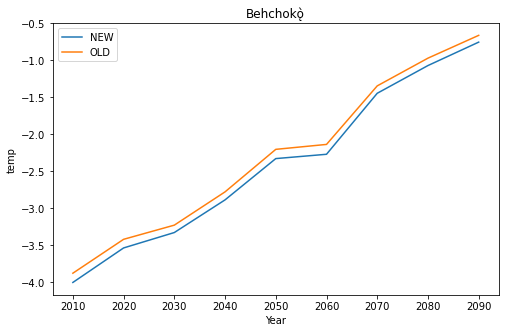

In [14]:
plt.figure(figsize=(8, 5))
old_inuvik = di_csv['master']['rcp60']['csv'].query("model == '5ModelAvg' and community == 'Behchoko (Edzo)'")
new_inuvik = di_csv['fix-point-locations-and-names']['rcp60']['csv'].query("model == '5ModelAvg' and name == 'Behchokǫ̀'")

plt.plot(new_inuvik[['year', 'tas']].groupby('year').mean(), label='NEW')
plt.plot(old_inuvik[['year', 'tas']].groupby('year').mean(), label='OLD')    
plt.legend()
plt.title('Behchokǫ̀')
plt.xlabel('Year')
plt.ylabel('temp')

Text(0, 0.5, 'temp')

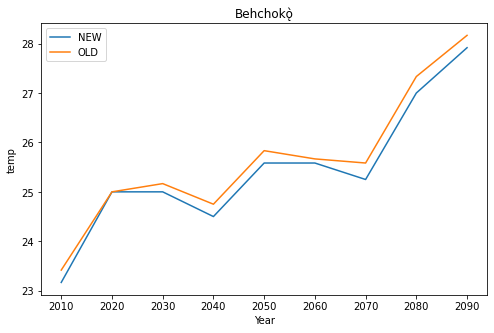

In [15]:
plt.figure(figsize=(8, 5))
old_inuvik = di_csv['master']['rcp60']['csv'].query("model == '5ModelAvg' and community == 'Behchoko (Edzo)'")
new_inuvik = di_csv['fix-point-locations-and-names']['rcp60']['csv'].query("model == '5ModelAvg' and name == 'Behchokǫ̀'")

plt.plot(new_inuvik[['year', 'pr']].groupby('year').mean(), label='NEW')
plt.plot(old_inuvik[['year', 'pr']].groupby('year').mean(), label='OLD')    
plt.legend()
plt.title('Behchokǫ̀')
plt.xlabel('Year')
plt.ylabel('temp')